## Real-time human detection
- reference link: https://github.com/akash435/Real-Time-Human-Detection-Counting

In [86]:
import tensorflow as tf
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

import numpy as np
import pandas as pd
pd.set_option('display.max_rows', None)

import matplotlib.pyplot as plt
import cv2
import time
import os
import glob

from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix

## Load pre-trained model as tf.Graph

In [2]:
class DetectorAPI:
    def __init__(self):
        self.path_to_ckpt = f'../model/frozen_inference_graph.pb'
        self.detection_graph = tf.Graph()

        with self.detection_graph.as_default():
            od_graph_def = tf.GraphDef()
            with tf.gfile.GFile(self.path_to_ckpt, 'rb') as fid:
                serialized_graph = fid.read()
                od_graph_def.ParseFromString(serialized_graph)
                tf.import_graph_def(od_graph_def, name='')

        self.default_graph = self.detection_graph.as_default()
        self.sess = tf.Session(graph=self.detection_graph)

        self.image_tensor = self.detection_graph.get_tensor_by_name('image_tensor:0')
        self.detection_boxes = self.detection_graph.get_tensor_by_name('detection_boxes:0')
        self.detection_scores = self.detection_graph.get_tensor_by_name('detection_scores:0')
        self.detection_classes = self.detection_graph.get_tensor_by_name('detection_classes:0')
        self.num_detections = self.detection_graph.get_tensor_by_name('num_detections:0')

    def processFrame(self, image):
        # Expand dimensions since the trained_model expects images to have shape: [1, None, None, 3]
        image_np_expanded = np.expand_dims(image, axis=0)
        # Actual detection.
        start_time = time.time()
        (boxes, scores, classes, num) = self.sess.run(
            [self.detection_boxes, self.detection_scores,
                self.detection_classes, self.num_detections],
            feed_dict={self.image_tensor: image_np_expanded})
        end_time = time.time()

        im_height, im_width, _ = image.shape
        boxes_list = [None for i in range(boxes.shape[1])]

        for i in range(boxes.shape[1]):
            boxes_list[i] = (int(boxes[0, i, 0] * im_height),int(boxes[0, i, 1]*im_width),int(boxes[0, i, 2] * im_height),int(boxes[0, i, 3]*im_width))

        return boxes_list, scores[0].tolist(), [int(x) for x in classes[0].tolist()], int(num[0])

    def close(self):
        self.sess.close()
        self.default_graph.close()

In [67]:
def plot_image(indices, boxes, classes, scores, image, image_id):
    area, pct_area, confs = [], 0, []
    for i in indices:
        box = boxes[i[0]]
        # filter human class, class_label = 1
        if classes[i[0]] == 1:
            cv2.rectangle(image, 
                          (box[1], box[0]), 
                          (box[3], box[2]), 
                          (255, 0, 0), 2)
            area.append((box[3] - box[1]) * (box[2] - box[0]))
            confs.append(scores[i[0]])
    
    if len(area) == 0:
        pct_area, avg_conf = 0, 0
    else:
        pct_area = np.mean(area) / (image.shape[0] * image.shape[1])
        avg_conf = np.mean(confs)
    
    plt.figure()
    plt.title("Image {}: {:.0%}% of area is classified as person at {:.0%}% confidence".format(
                    image_id, pct_area, avg_conf)
    )
    plt.imshow(image)
    plt.show()
    plt.close()
    
    return pct_area, avg_conf

## Human detection

In [4]:
odapi = DetectorAPI()

In [6]:
image_ids = [int(x.split("/")[-1].split(".")[0]) for x in glob.glob("../../../HKTVMall_data/*.jpg")]
image_ids.sort()
len(image_ids)

100

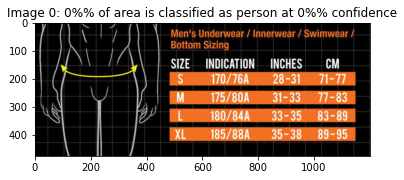

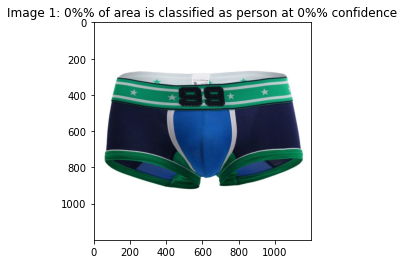

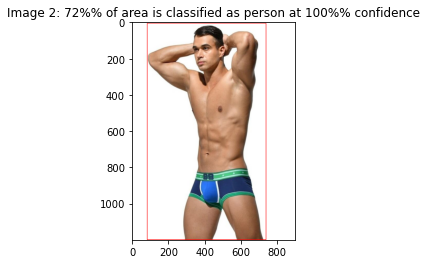

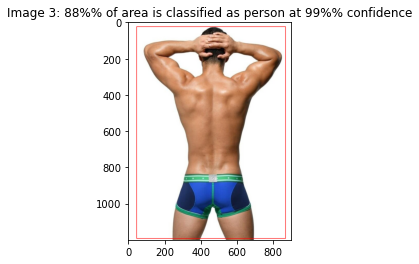

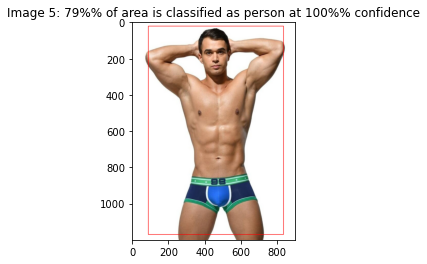

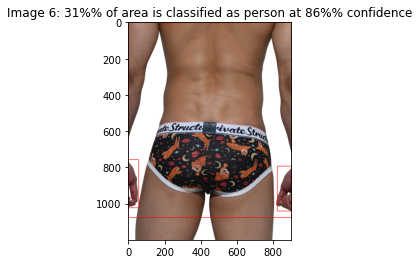

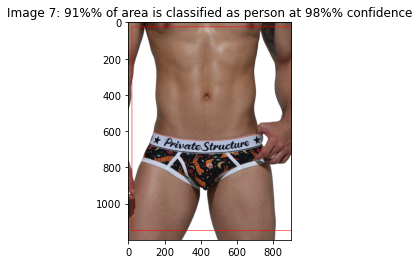

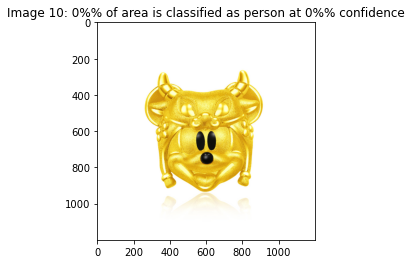

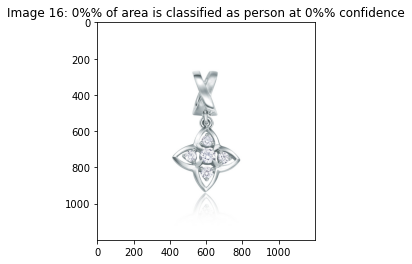

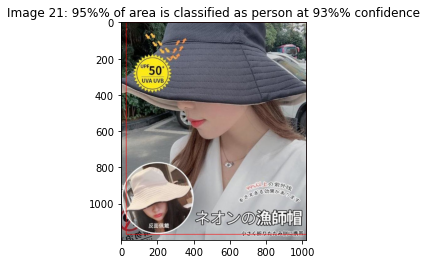

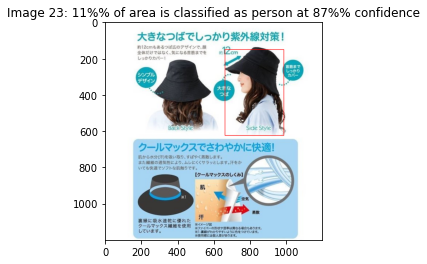

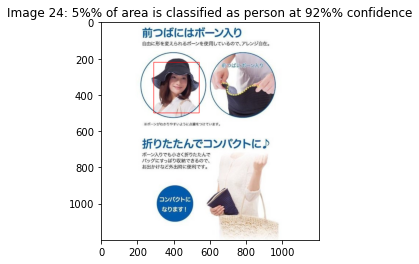

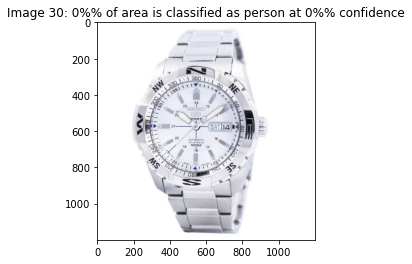

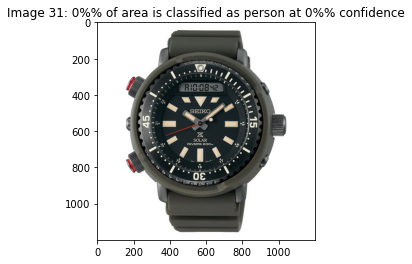

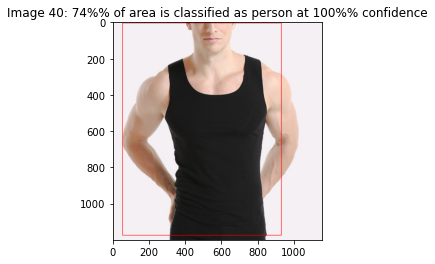

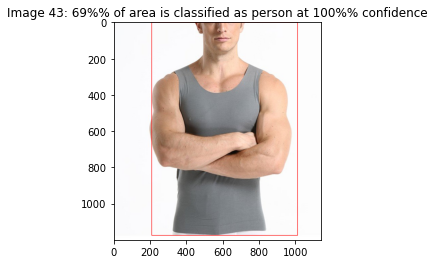

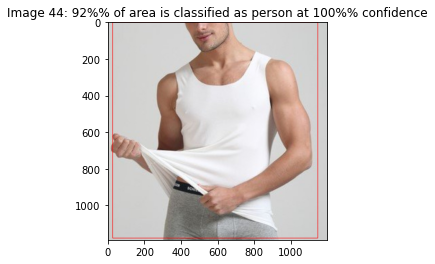

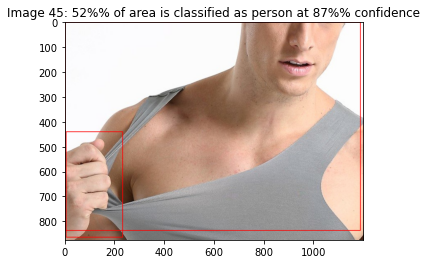

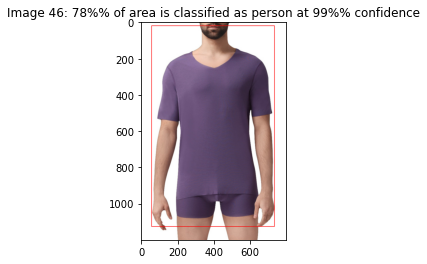

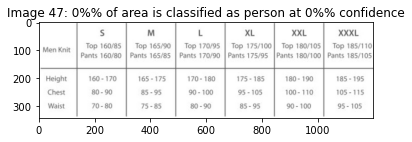

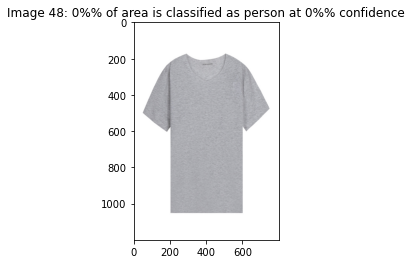

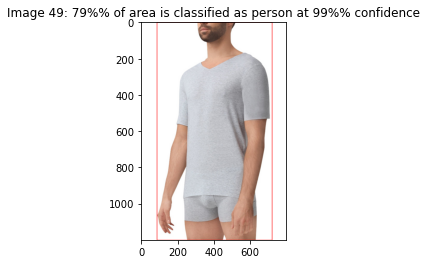

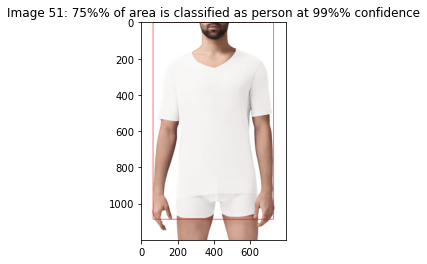

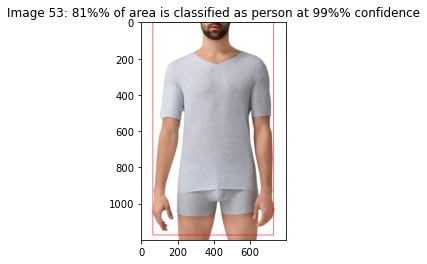

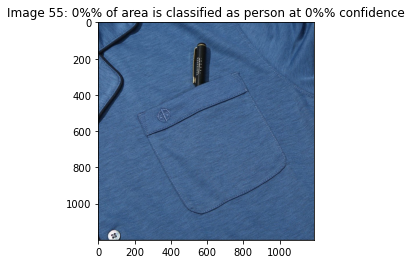

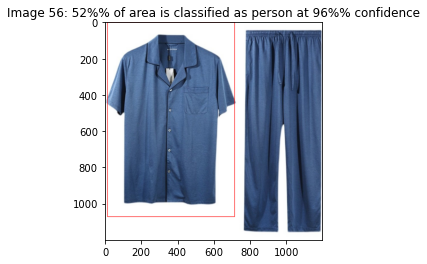

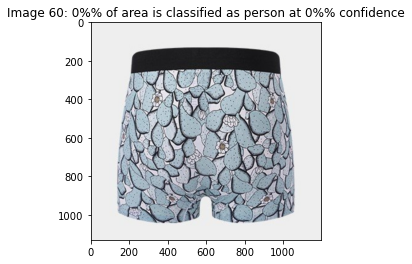

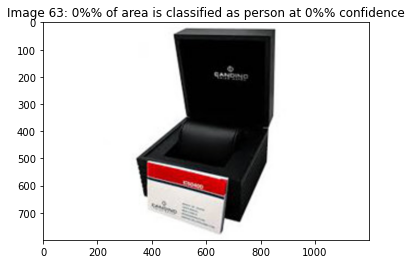

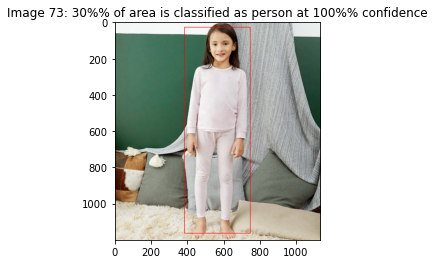

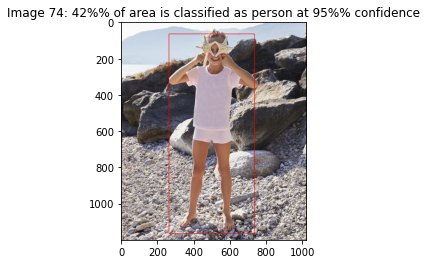

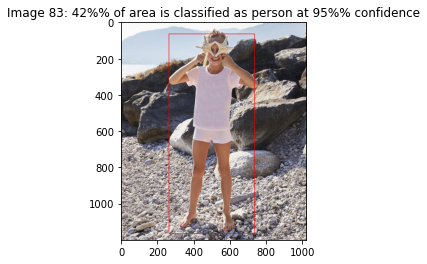

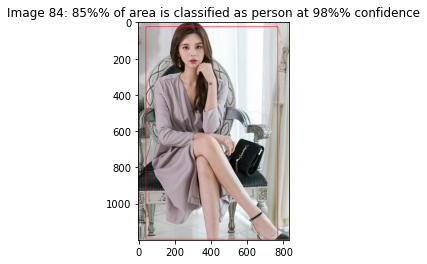

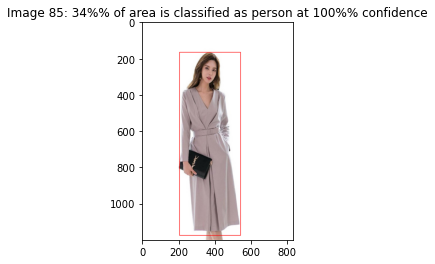

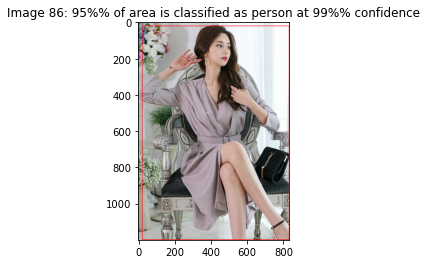

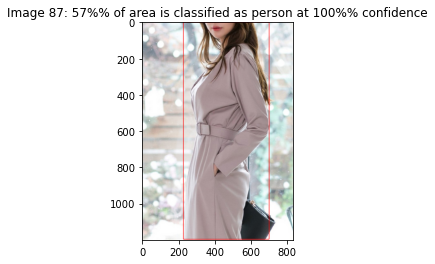

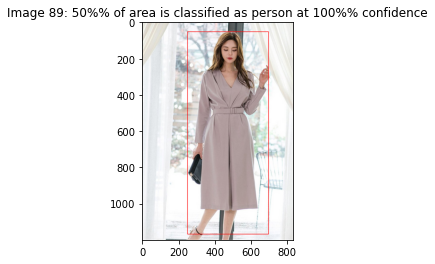

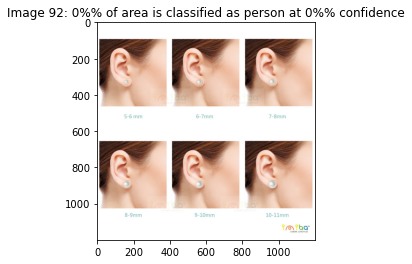

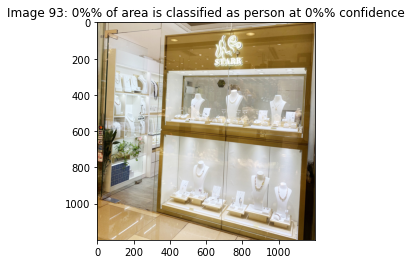

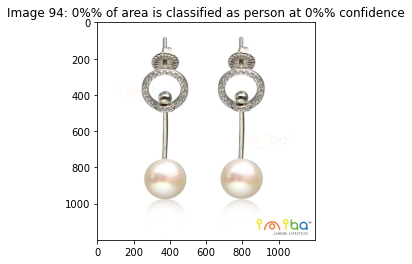

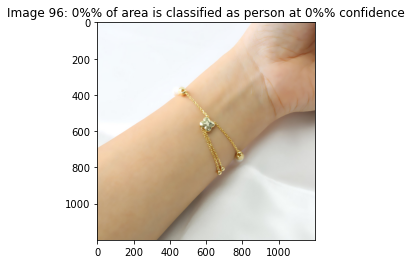

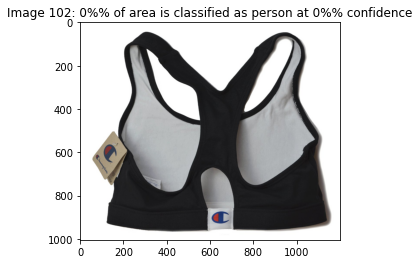

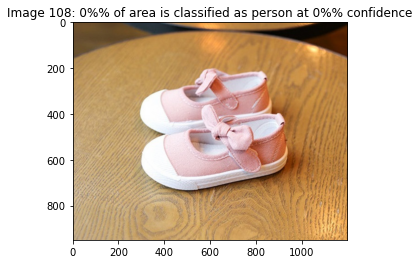

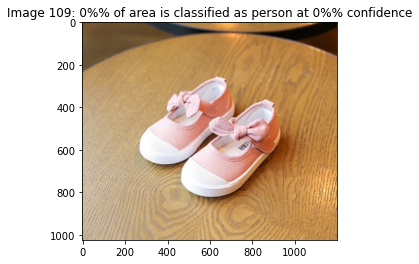

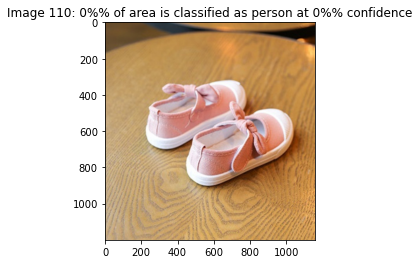

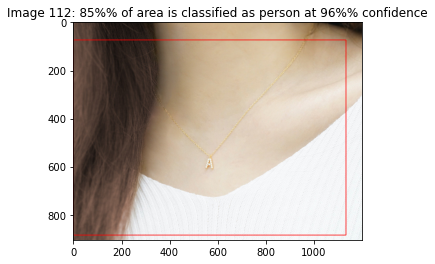

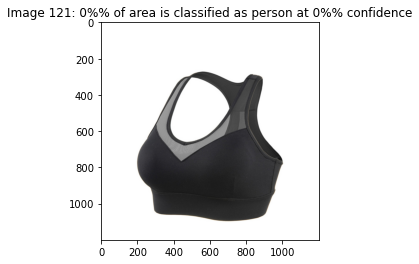

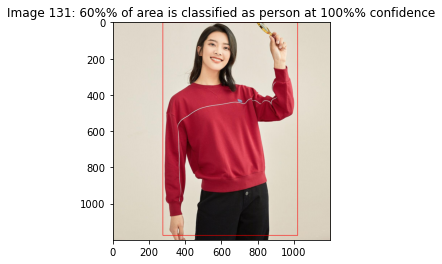

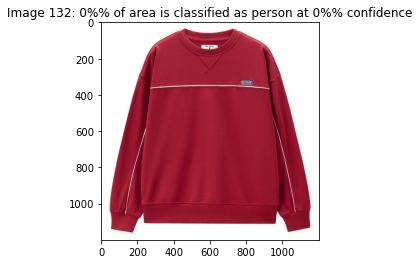

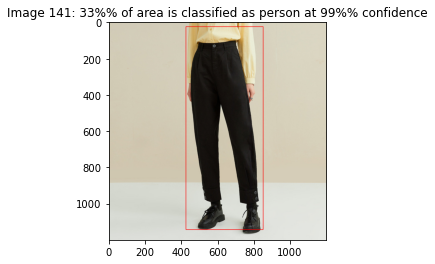

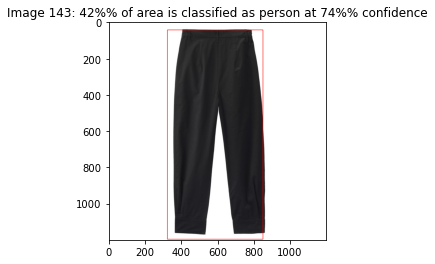

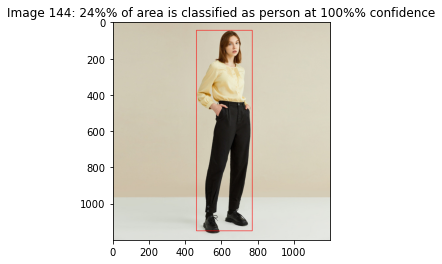

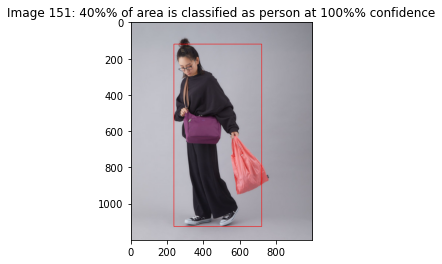

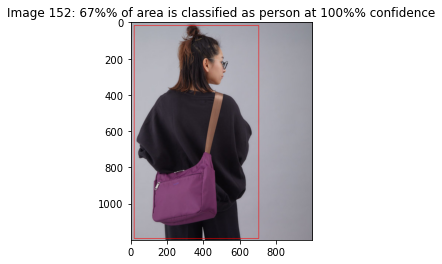

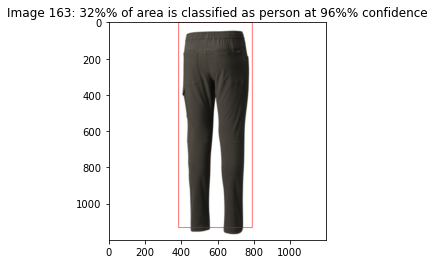

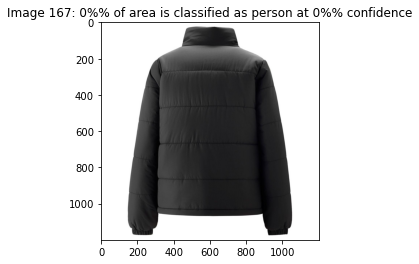

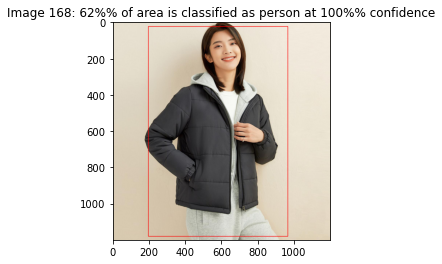

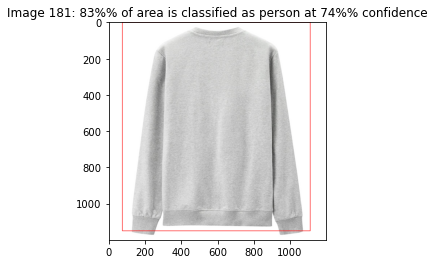

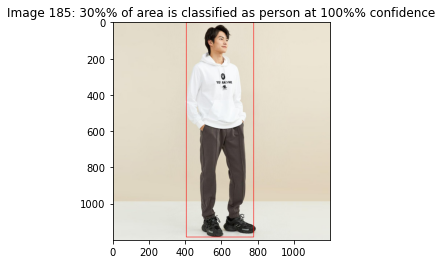

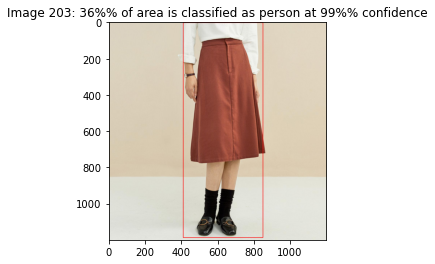

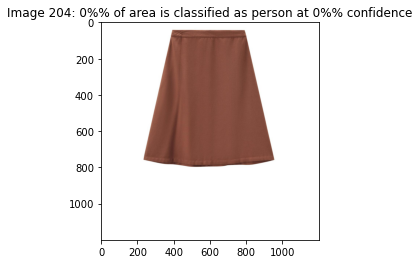

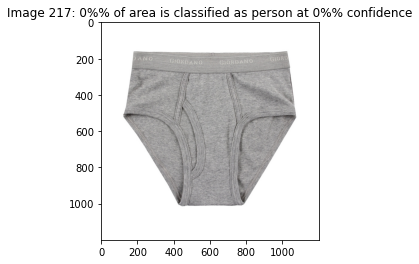

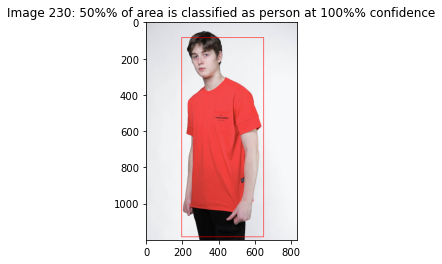

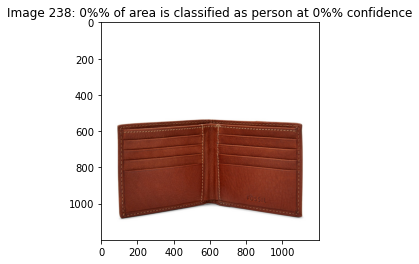

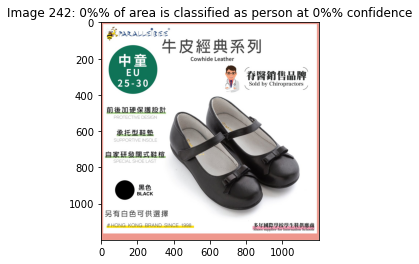

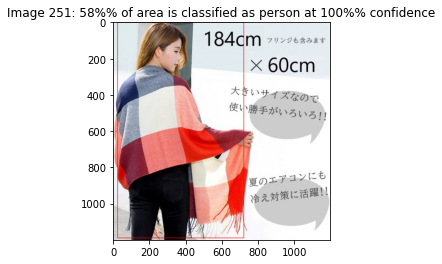

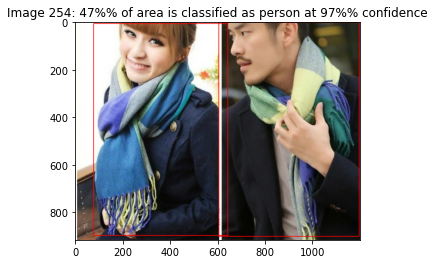

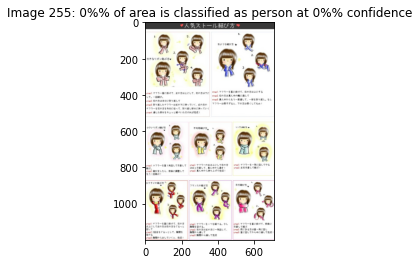

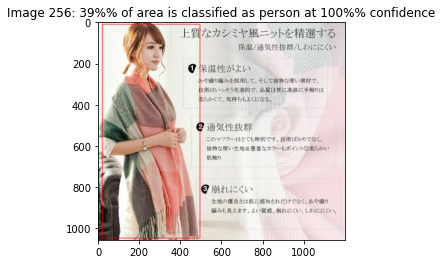

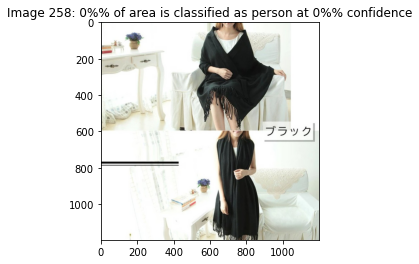

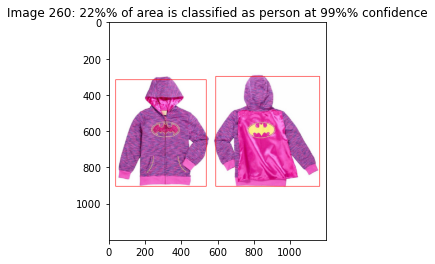

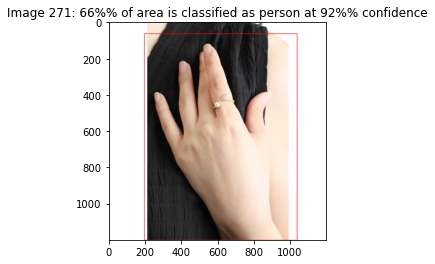

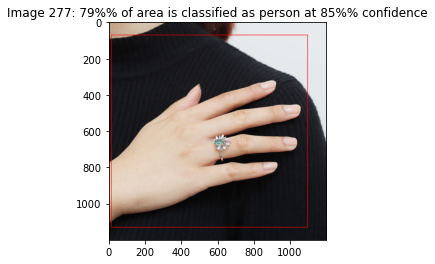

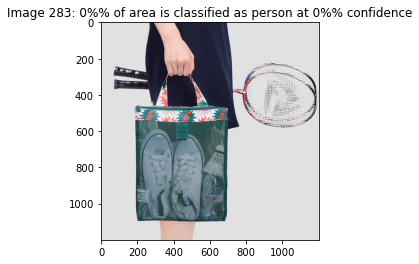

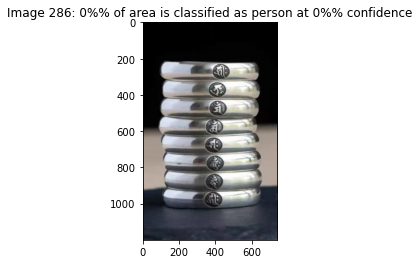

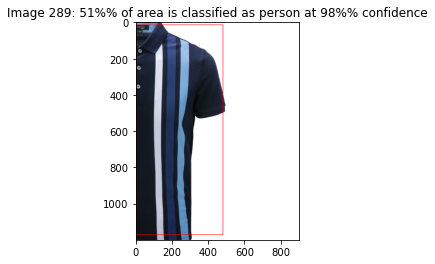

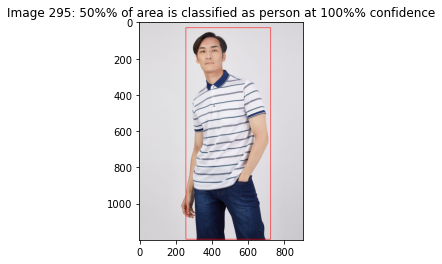

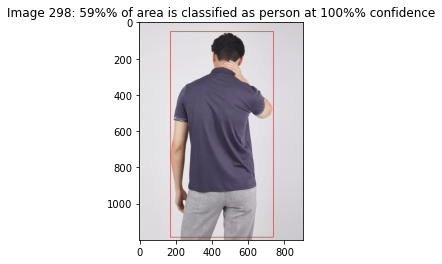

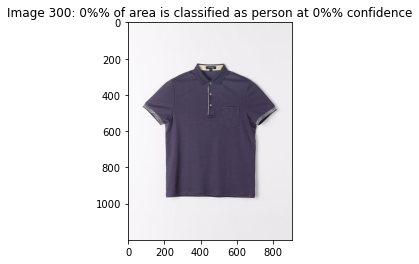

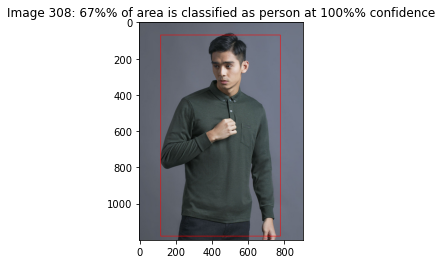

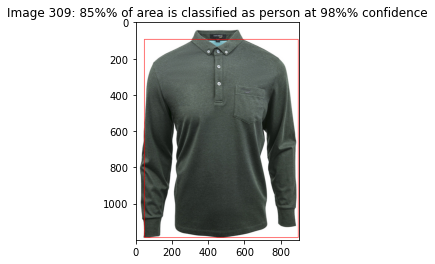

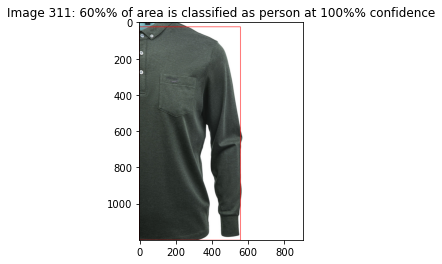

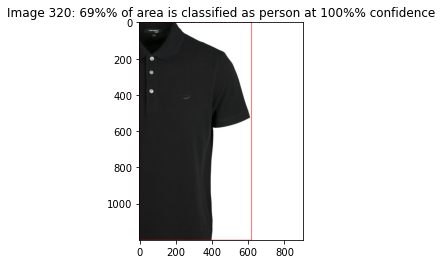

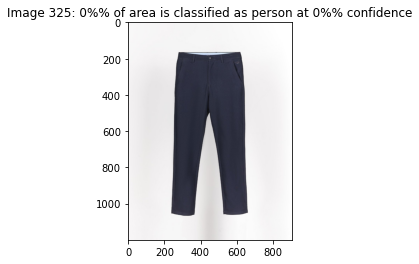

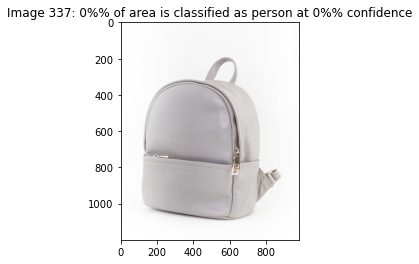

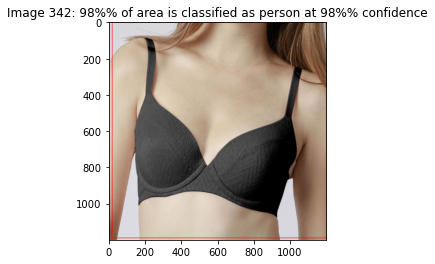

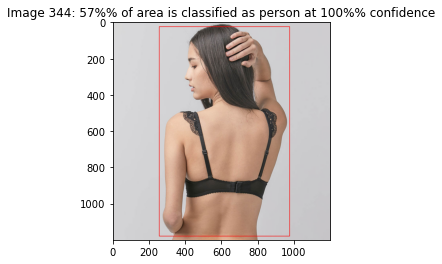

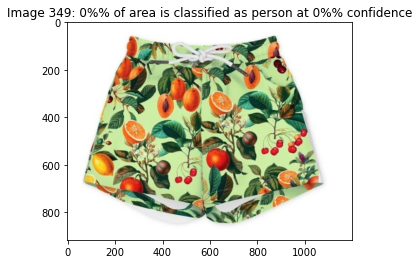

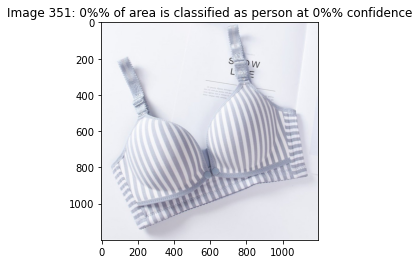

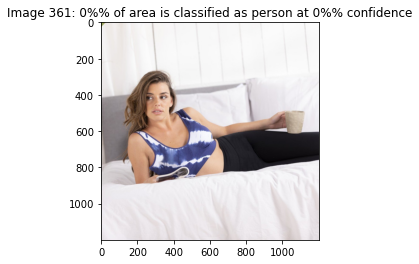

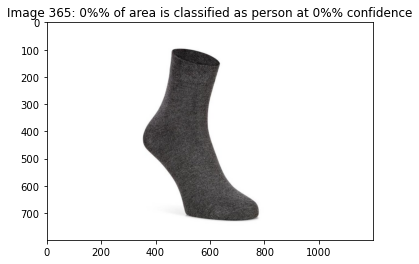

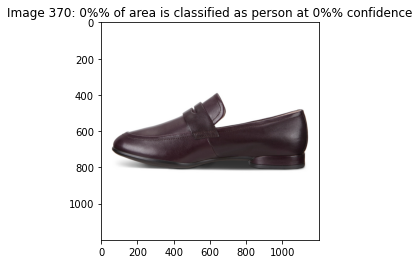

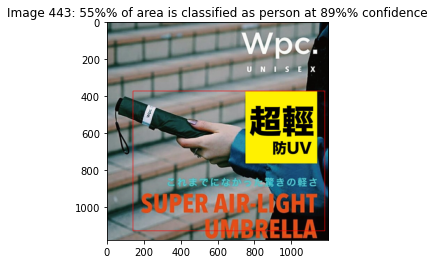

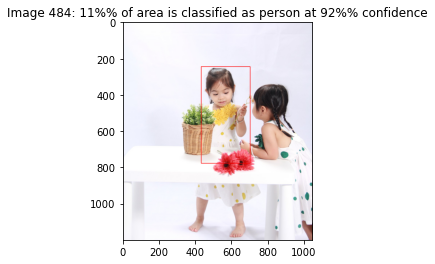

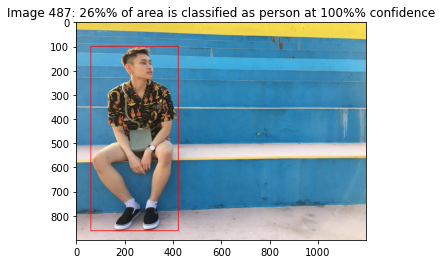

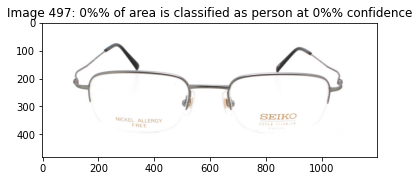

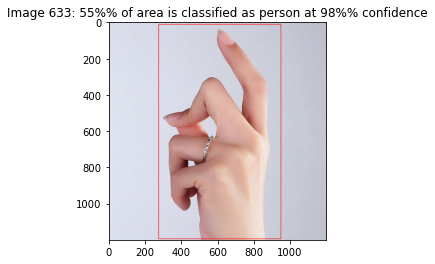

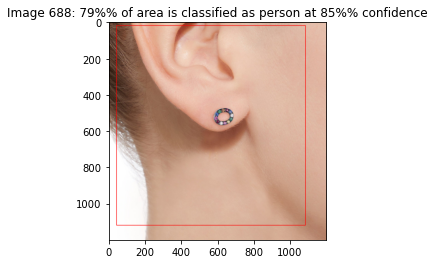

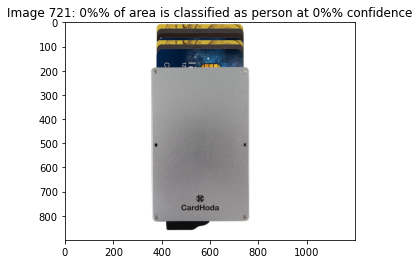

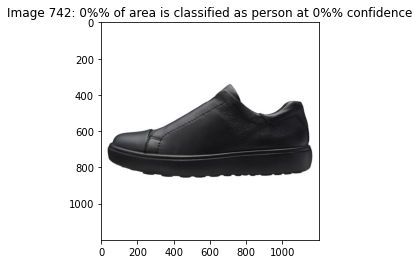

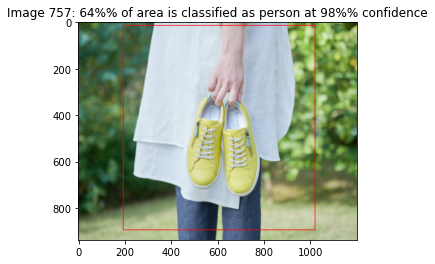

Total time used: 53.55


In [91]:
start = time.time()

result_dict = {"image_id": [], "pct_area": [], "avg_conf": [], "pred_label": []}
conf_thres = 0.7

for image_id in image_ids:
    image = cv2.imread("../../../HKTVMall_data/%d.jpg" % image_id)
    img = cv2.resize(image, (image.shape[1], image.shape[0]))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    boxes, scores, classes, num = odapi.processFrame(img)

    # filter boxes using confidence threshold = 0.7, non maximum suppression threshold = 0.1
    indices = cv2.dnn.NMSBoxes(boxes, scores, conf_thres, 0.1)
    pct_area, avg_conf = plot_image(indices, boxes, scores, classes, image, image_id)

    if pct_area > 0.05:
        result_dict["pred_label"].append(1)
    else:
        result_dict["pred_label"].append(0)
    
    result_dict["image_id"].append(image_id)
    result_dict["pct_area"].append(pct_area)
    result_dict["avg_conf"].append(avg_conf)
    

result_df = pd.DataFrame.from_dict(result_dict, orient="columns")
result_df = result_df.sort_values("image_id")
result_df.to_csv("result/real_time_pred.csv", index=False)


end = time.time()
print("Total time used: %.2f" % (end-start))

In [40]:
yolo_res = pd.read_csv("result/yolo_320_result.csv")
par_res = pd.read_csv("result/human_parsing_result.csv")
real_time_res = pd.read_csv("result/real_time_pred.csv")

label = pd.read_csv("result/true_label.csv")

## Performance

In [87]:
def evaluate(model_name, df, pred_col, label_col="y_true"):
    acc = accuracy_score(df["y_true"], res[pred_col])
    precision = precision_score(df["y_true"], res[pred_col])
    recall = recall_score(df["y_true"], res[pred_col])
    f1 = f1_score(df["y_true"], res[pred_col])
    
    print(model_name)
    print("accuracy: {:.2%}".format(acc), 
          "precision: {:.2%}".format(precision), 
          "recall: {:.2%}".format(recall),
          "f1: {:.2%}".format(f1))
    print("confusion matrix")
    print(confusion_matrix(df["y_true"], res[pred_col]), "\n")

- confusion matrix: [TP FP], [FN TN]

In [89]:
res = yolo_res.merge(label, on="image_id")
evaluate("YOLOv3", res, "yolo_pred", label_col="y_true")

res = real_time_res.merge(label, on="image_id")
evaluate("Real-time human detection", res, "pred_label", label_col="y_true")

res = par_res.merge(label, on="image_id")
evaluate("Human Parsing", res, "par_pred", label_col="y_true")

YOLOv3
accuracy: 89.00% precision: 86.67% recall: 94.55% f1: 90.43%
confusion matrix
[[37  8]
 [ 3 52]] 

Real-time human detection
accuracy: 86.00% precision: 84.75% recall: 90.91% f1: 87.72%
confusion matrix
[[36  9]
 [ 5 50]] 

Human Parsing
accuracy: 85.00% precision: 97.62% recall: 74.55% f1: 84.54%
confusion matrix
[[44  1]
 [14 41]] 



In [85]:
res[res["pred_label"] != res["y_true"]]

image_id  pct_area  avg_conf  pred_label  y_true
25        56  0.520625  0.958349           1       0
36        92       NaN       NaN           0       1
39        96       NaN       NaN           0       1
49       143  0.420800  0.741906           1       0
53       163  0.318094  0.958490           1       0
56       181  0.825046  0.741518           1       0
68       258       NaN       NaN           0       1
69       260  0.221866  0.986836           1       0
72       283       NaN       NaN           0       1
74       289  0.509997  0.980540           1       0
79       309  0.852847  0.982257           1       0
80       311  0.604965  0.996834           1       0
81       320  0.685841  0.995309           1       0
88       361       NaN       NaN           0       1

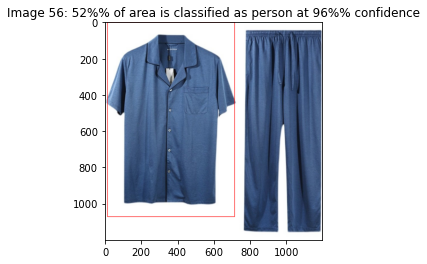

class: 1
bounding box area: (0, 13, 1071, 713)
confidence: 0.9583


In [90]:
image_id = 56
image = cv2.imread("../../HKTVMall_data/%d.jpg" % image_id)
img = cv2.resize(image, (image.shape[1], image.shape[0]))
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
boxes, scores, classes, num = odapi.processFrame(img)

# filter boxes using confidence threshold = 0.7, non maximum suppression threshold = 0.1
indices = cv2.dnn.NMSBoxes(boxes, scores, conf_thres, 0.1)
pct_area, avg_conf = plot_image(indices, boxes, scores, classes, image, image_id)

for i in indices:
    print("class: %d" % classes[i[0]])
    print("bounding box area:", boxes[i[0]])
    print("confidence: %.4f" % scores[i[0]])